C:\Users\Bartek\AppData\Local\Temp\ipykernel_5088\2111302420.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


[*********************100%%**********************]  1 of 1 completed


,date,open,high,low,close,aclose,volume
5179,2023-11-16,1.085458,1.089396,1.083095,1.085458,1.085458,0
5180,2023-11-17,1.085376,1.089230,1.082520,1.085376,1.085376,0
5181,2023-11-20,1.090703,1.094511,1.089800,1.090703,1.090703,0
5182,2023-11-21,1.094595,1.096732,1.092299,1.094595,1.094595,0
5183,2023-11-22,1.091584,1.092538,1.085658,1.088258,1.088258,0


<Axes: xlabel='date'>

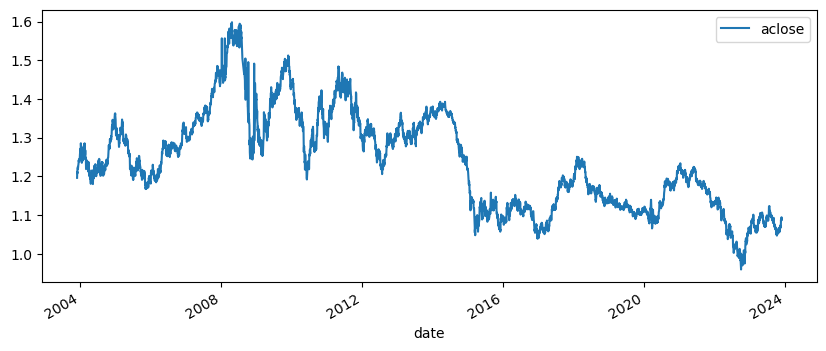

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
from IPython.core.display import display
%matplotlib inline

import yfinance as yf

data = yf.download('EURUSD=X', start='2000-01-01', end='2023-12-31')
data.reset_index(inplace=True)
data.columns = ['date', 'open', 'high', 'low', 'close', 'aclose', 'volume']
#*Close price adjusted for splits.**Aclose price adjusted for splits and dividend and/or capital gain distributions.
df = pd.DataFrame(data)
display(df.tail())
df.plot(x='date', y='aclose', figsize=(10,4))

<Axes: xlabel='date'>

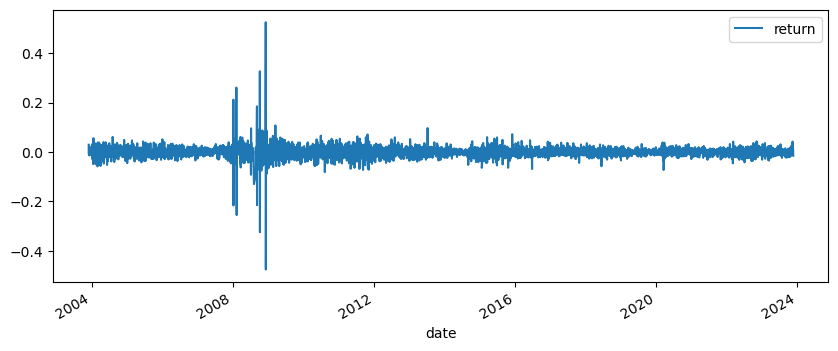

In [2]:
# Normalizacja wartości aclose 
# Wartość ta jest wykorzystywana do trenowania modelu

df['return'] = df['aclose'] - df['aclose'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot(x='date', y='return', figsize=(10,4))

In [3]:
# 1 gdy cena wzrosła, 0 gdy cena spadła

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
df.dropna(inplace=True)
df

,date,open,high,low,close,aclose,volume,return,label
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0,0.029564,1
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0,0.008109,0
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0,-0.010025,1
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0,0.025281,1
5,2003-12-08,1.216797,1.224005,1.215407,1.222001,1.222001,0,0.007885,1
...,...,...,...,...,...,...,...,...,...
5179,2023-11-16,1.085458,1.089396,1.083095,1.085458,1.085458,0,-0.005660,0
5180,2023-11-17,1.085376,1.089230,1.082520,1.085376,1.085376,0,-0.000197,1
5181,2023-11-20,1.090703,1.094511,1.089800,1.090703,1.090703,0,0.012705,1
5182,2023-11-21,1.094595,1.096732,1.092299,1.094595,1.094595,0,0.009282,0


In [4]:
# Tworzenie danych testowych

n_features = 60 
train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i<n_features:
        continue
    
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.iloc[i]['label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

(5123, 60)
(5123,)
% of Class0 : 0.501464
% of Class1 : 0.498536


In [5]:
# Używamy 95% danych do trenowania modelu i 5% do testowania 

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.1, n_estimators=10)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.582342


Text(0, 0.5, 'Equity (USD)')

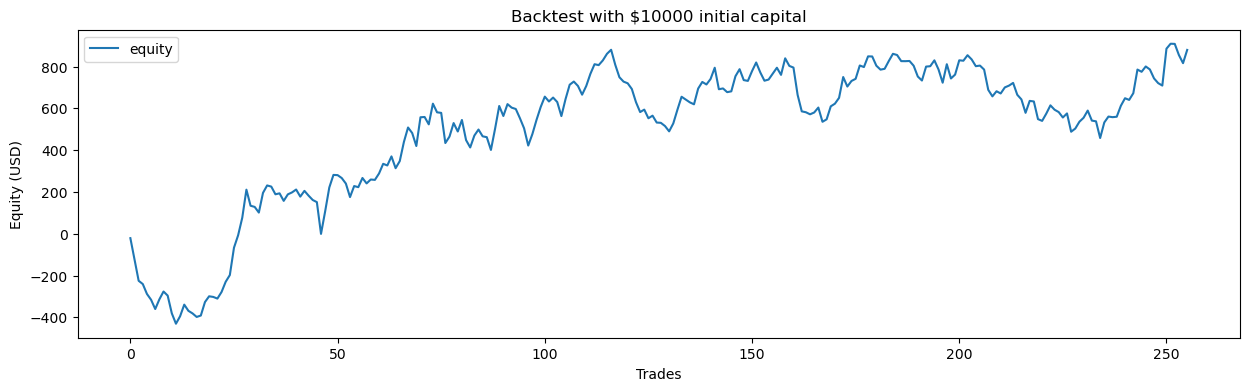

In [6]:
# Przewidywania danych testowych 

pred = clf.predict(train_x[train_len:])

contracts  = 10000.0
commission = 0.0

df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

#display(df_trade.tail())
df_trade.plot(y='equity', figsize=(15,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')

Net Profit            : $879.53
Number Winning Trades : 123
Number Losing Trades  : 133
Percent Profitable    : 48.05%
Avg Win Trade         : $45.141
Avg Los Trade         : $-35.134
Largest Win Trade     : $176.489
Largest Los Trade     : $-151.905


C:\Users\Bartek\AppData\Local\Temp\ipykernel_5088\3081545758.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])


<Axes: >

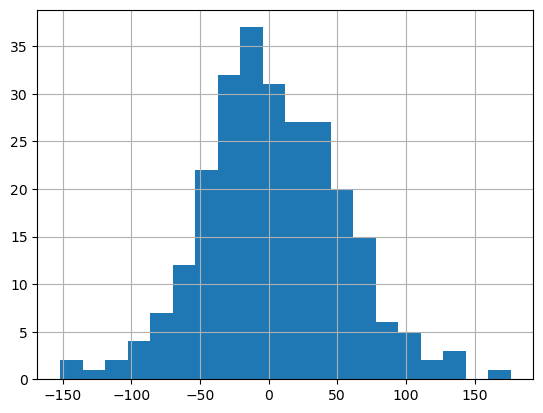

In [7]:
#Podsumowanie wszystkich tradów

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())

df_trade['pnl'].hist(bins=20)